<a href="https://colab.research.google.com/github/akatukam/Image-Classifier/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anuja Katukam and Arav Patel

In [2]:
import os
import tarfile

if not os.path.isfile('./data.tar.gz'):
    !wget 'http://cs.umd.edu/~pulkit/hw_3_data.tar.gz' -O data.tar.gz

with tarfile.open('./data.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./')


--2025-04-01 20:37:01--  http://cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving cs.umd.edu (cs.umd.edu)... 128.8.127.4
Connecting to cs.umd.edu (cs.umd.edu)|128.8.127.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz [following]
--2025-04-01 20:37:01--  http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving www.cs.umd.edu (www.cs.umd.edu)... 128.8.127.4
Reusing existing connection to cs.umd.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 7171530 (6.8M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   6.84M  2.42MB/s    in 2.8s    

2025-04-01 20:37:05 (2.42 MB/s) - ‘data.tar.gz’ saved [7171530/7171530]



### Dataset class

In [3]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
import os
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, csv_path, data_root, transform=None, device='cpu'):
        self.transform = transform
        self.root_path = data_root
        self.device = device

        # Read the csv file. You can use the pandas library
        data = pd.read_csv(csv_path)

        # Get the image paths from the csv
        self.image_paths = data['image_path'].tolist()

        # Get the class ids from the csv
        if 'class_id' in data.columns:
            self.class_ids = data['class_id'].tolist()
        else:
            self.class_ids = None

        # Get the image names from the csv
        self.image_names = data['image_name'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        rel_img_path = self.image_paths[idx]
        image_name = self.image_names[idx]
        img = cv2.imread(rel_img_path)

        # Check if the image was loaded successfully
        if img is None:
          print(f"Failed to load image at {rel_img_path}")
          raise FileNotFoundError(f"No image found at {rel_img_path}")
        # Convert the NumPy array (img) to a PIL Image

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        # img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.0  # Reorder dimensions and normalize

        if self.class_ids is None: # for testing purposes
            return img, image_name, rel_img_path
        else:
            class_id = torch.tensor(self.class_ids[idx], dtype=torch.long)
            return img.to(self.device), class_id.to(self.device)

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms as T

def plot_image(img, title=None):
  img = img.permute(1, 2, 0)
  plt.imshow(img)
  if title:
      plt.title(title)
  plt.axis('off')
  plt.show()

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize to ensure all images are the same size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

csv_path = '/content/data/csvs/train.csv'
data_root = '/content'

# Create an instance of the CustomImageDataset class for the training dataset
dataset = CustomImageDataset(csv_path=csv_path, data_root=data_root, transform=transform, device='cpu')


### Model definition

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Create one or more convolutional neural network layers. This is just a suggestion.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Define dropout to reduce overfitting
        self.dropout = nn.Dropout(0.25)

        # Create one or more feed forward layers. This is just a suggestion.
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # After three pooling layers, the feature map will be 8x8
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        # Apply first convolutional layer, followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolutional layer, followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Apply third convolutional layer, followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output from the convolutional layers
        x = torch.flatten(x, 1)

        # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        # Final fully connected layer to output class scores
        x = self.fc2(x)

        return x

### Training

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 16
learning_rate = 1e-4

# Exploring different transformation functions
transform = T.Compose([
    T.Resize((64, 64)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_root = "./"

# Create an instance of the CustomImageDataset class for the training and validation datasets
csv_path_train = '/content/data/csvs/train.csv'
csv_path_val = '/content/data/csvs/val.csv'

train_set = CustomImageDataset(csv_path=csv_path_train, data_root=img_root, transform=transform, device=device)
val_set = CustomImageDataset(csv_path=csv_path_val, data_root=img_root, transform=transform, device=device)

# Create two dataloaders for bothe datasets.
# Shuffle the training dataloader. This is important to prevent the model from learning the order of the data.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Initialize the model
n_classes = 10
model = ImageClassifier(n_classes=10).to(device)

# Initialize the Adam optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Instantiate the loss function.
loss_fn = nn.CrossEntropyLoss()

# Training loop
eval_every = 2
n_epochs = 10
val_loss_values = []
training_loss_values = []
eval_epochs = []

for epoch in range(n_epochs):
    # set model to training mode
    model.train()
    total_loss = 0
    for img, label in tqdm(train_loader):

        # Make a forward pass (predict the class of the image)
        pred = model(img)

        # Calculate the loss
        loss = loss_fn(pred, label)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation loop
    if epoch > 0 and epoch % eval_every == 0:
        model.eval()
        total_val_loss = 0
        count = 0
        # Don't calculate gradients when evaluating model
        with torch.no_grad():
            for img, label in tqdm(val_loader):
                pred = model(img)
                val_loss = loss_fn(pred, label)
                total_val_loss += val_loss.item()
                count += 1

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = total_val_loss / count

        print(f"Epoch: {epoch}, Train Loss: {avg_train_loss} Eval Loss: {avg_val_loss}")
        eval_epochs.append(epoch)
        training_loss_values.append(avg_train_loss)
        val_loss_values.append(avg_val_loss)


# Save model's weights
torch.save(model.state_dict(), "model.pth")

100%|██████████| 32/32 [00:00<00:00, 97.31it/s]


Epoch: 2, Train Loss: 1.4838269812629579 Eval Loss: 1.4851748598739505


100%|██████████| 32/32 [00:00<00:00, 92.50it/s]


Epoch: 4, Train Loss: 1.269047387102817 Eval Loss: 1.425502804107964


100%|██████████| 32/32 [00:00<00:00, 103.12it/s]


Epoch: 6, Train Loss: 1.1115890928405396 Eval Loss: 1.3398676705546677


100%|██████████| 32/32 [00:00<00:00, 103.40it/s]


Epoch: 8, Train Loss: 0.9994646312391504 Eval Loss: 1.3222198318690062


100%|██████████| 188/188 [00:02<00:00, 69.51it/s]


### Plot your training and validation loss

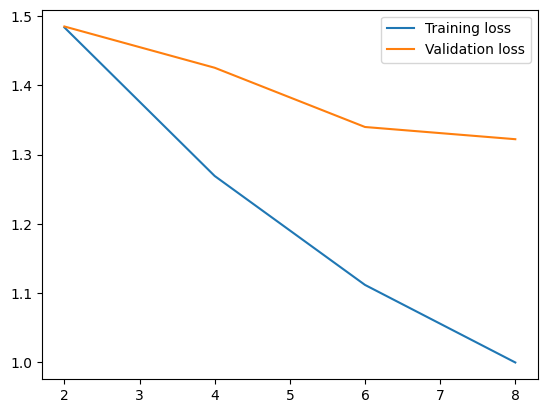

In [7]:
# Plot the training and validation loss
plt.plot(eval_epochs, training_loss_values, label='Training loss')
plt.plot(eval_epochs, val_loss_values, label='Validation loss')
plt.legend()
plt.show()

### Test model against the validation dataset

In [12]:
## Load from saved model
import numpy as np
import torch

# Load from saved model using torch.load
model = ImageClassifier(n_classes=10).to(device)  # Ensure to use the same n_classes as used during training
model_state_dict = torch.load("./model.pth", map_location=device)  # Add map_location to ensure it loads on the right device
model.load_state_dict(model_state_dict)
model.eval()

# set model to inference mode
model.eval()
batch_size = 1

# Load the validation dataset
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = CustomImageDataset(csv_path='/content/data/csvs/val.csv', data_root='/content', transform=val_transform, device=device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

preds = []
model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())

# Get the true labels for the validation dataset
true_labels = [label.cpu() for _, label in test_dataset]

preds = np.array(preds)
true_labels = np.array(true_labels)

accuracy = (preds == true_labels).sum() / len(true_labels)

100%|██████████| 500/500 [00:00<00:00, 729.92it/s]


### Evaluation

In [9]:
## Load from saved model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load from saved model using torch.load
model = ImageClassifier(n_classes=10).to(device)  # Initialize the model as before
model_state_dict = torch.load("./model.pth", map_location=device)
model.load_state_dict(model_state_dict)
model.eval()

# Load the test data
test_dataset = CustomImageDataset(csv_path='/content/data/csvs/test.csv', data_root='/content', transform=val_transform, device=device)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

final_preds = []
with torch.no_grad():
    for img, img_names, img_paths in tqdm(test_loader):
        img = img.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs, 1)  # Get the predicted class index

        batch_preds = [
            (img_name, pred_img.item(), img_path)
            for img_name, pred_img, img_path in zip(img_names, pred.cpu().numpy(), img_paths)
        ]
        final_preds.extend(batch_preds)


100%|██████████| 47/47 [00:00<00:00, 62.34it/s]


In [10]:
test_prediction = pd.DataFrame(final_preds, columns=['image_name', 'prediction', 'image_path'])
test_prediction.to_csv('prediction.csv')

from google.colab import files
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>